### **TODO: Detailed description of this analysis**

---



---



---



### ***Setup and Initialization***

---



In [32]:
# Import output module to clear output for cells after execution
from google.colab import output

Earth Engine Install.

In [33]:
!pip install earthengine-api #earth-engine Python API
output.clear()

### ***Earth Engine initialize / authenticate.***

In [34]:
import ee
try:
  ee.Initialize()
except ee.EEException:
  !earthengine authenticate

output.clear()

### ***Setup and Init (Continued)***

Import geemap for mapping visualization.

In [35]:
!pip install geemap
import geemap.eefolium as emap

output.clear()

Install geetools for cloud masking.

In [36]:
!pip install geetools
from geetools import ui, cloud_mask

output.clear()

Import pandas dataframes.
Import numpy.

In [37]:
!pip install geopandas
import geopandas as gpd 
import numpy as np
from datetime import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt


output.clear()

### **Set initial variables - extent, center, roi.**

---



In [38]:
ctr = [27.80419, 86.71282]
Map = emap.Map(center=ctr, zoom=14)
Map.add_basemap('SATELLITE')

extent = ee.FeatureCollection(
        [ee.Feature(
            ee.Geometry.Polygon(
                [[[86.53302314798783, 28.023956618036586],
                  [86.53302314798783, 27.5403943025769],
                  [86.95050361673783, 27.5403943025769],
                  [86.95050361673783, 28.023956618036586]]]))])

roi = ee.FeatureCollection(
        [ee.Feature(
            ee.Geometry.Point([86.72192082519531, 27.84834667224366]))])

### **Functions - resampling to 10m resolution, various vegetation indices.**

---

In [39]:
#Function to add ndvi
def addNDVI(img):
  return img.addBands(img.normalizedDifference(['B8','B4']).rename('ndvi'))


# Name	Normalized Difference NIR narrow/Red 
# Abbreviation	NDVI nar
# Formula: 	NIRnar−red / NIRnar+red  
def addNDVINarrow(img):
  return img.addBands(img.normalizedDifference(['B8A','B4']).rename('ndvi_nar'))


# Name	Normalized Difference NIR/Rededge Normalized Difference Red-Edge
# Abbreviation	NDRE
# Formula: 	NIR−rededge / NIR+rededge
def addNDVIRededge(img):
  return img.addBands(img.normalizedDifference(['B8','B5']).rename('ndvi_rededge'))


# Name	Normalized Difference NIRnar/Rededge Normalized Difference Red-Edge
# Abbreviation	NDRE
# Formula: 	NIRnar−rededge / NIRnar+rededge
def addNDVINarrowRededge(img):
  return img.addBands(img.normalizedDifference(['B8A','B5']).rename('ndvi_nar_rededge'))
  

# Add NDSI and LSWI
def addNDSIandLSWI(img):
  lswi1 = img.normalizedDifference(['B8', 'B11']).rename('lswi1')
  lswi2 = img.normalizedDifference(['B8', 'B12']).rename('lswi2')
  lswi1A = img.normalizedDifference(['B8A', 'B11']).rename('lswi1A')
  lswi2A = img.normalizedDifference(['B8A', 'B12']).rename('lswi2A')
  ndsi1 = img.normalizedDifference(['B3', 'B11']).rename('ndsi1')
  ndsi2 = img.normalizedDifference(['B3', 'B12']).rename('ndsi2')
  return img.addBands([lswi1, lswi2, lswi1A, lswi2A, ndsi1, ndsi2])
  

#Function to resample to 10m for Sentinel 2
def resample10m(img):
  b2 = img.select('B2')
  image10m = img.resample('bilinear').reproject(crs=b2.projection().crs(), scale=10)  
  return image10m


#Secondary cloud masking using binary classification - clouds
def cloudMaskBinary(img):
  
  lswi1 = img.normalizedDifference(['B8', 'B11']).rename('lswi1')
  lswi2 = img.normalizedDifference(['B8A', 'B12']).rename('lswi2')
  img = img.addBands([lswi1, lswi2])
  cloudPixelsTrain = getCloudPixels(img)
  imgTrain = img.addBands(cloudPixelsTrain.select('QA60'))
  
  bands = ['B5', 'B6', 'B7', 'B8', 'B8A', 'B10', 'B11', 'B12', 'QA60', 'lswi1', 'lswi2']

  trainingDataSetClouds = imgTrain.select(bands).stratifiedSample(
    numPoints=1000,
    scale=30,
    tileScale=10,
    seed=1,
    classBand='QA60'
  )

  classifierClouds = ee.Classifier.smileRandomForest(30, None, 1, 0.5, None, 1).train(
    features=trainingDataSetClouds,
    classProperty='QA60',
    inputProperties=bands
  )

  classified = img.classify(classifierClouds)
  
  #Mask where there are no clouds
  img = img.updateMask(classified.select('classification').eq(0))
  
  #Apply final cloud mask
  img = maskClouds(img)
  
  #Map.addLayer(img, visParams, 'classified masked', false)  
  return img


#Main - cloud masking
def maskClouds(img):
  qa = img.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  mask = qa.bitwiseAnd(cloudBitMask).eq(0) and (qa.bitwiseAnd(cirrusBitMask).eq(0))

  no_clouds = img.updateMask(mask)
  
  cirrBand = img.select('B10').lte(60)
  no_clouds = no_clouds.updateMask(cirrBand)
  return no_clouds.clip(extent)


#Return cloud pixels used for cloud binary classification
def getCloudPixels(img):
  qa = img.select("QA60")
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  #Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0) and (qa.bitwiseAnd(cirrusBitMask).eq(0)) 
  return mask


#This simple cloud mask uses a brightness threshold for clouds for sentinel images
def maskCloudSimple(img):
  expression = ('((B2 >= 1750 && B3 >= 1750 && B4 >= 1750) '
              # '|| (B2 >= 800 && B2 <= 950 && B3 >= 800 && B3 <= 950 && B4 >= 800 && B4 <= 950 && B10 >= 16) || '+
              # '|| B10 >= 60)'+
              ')  ? 1 : 0')

  bandDefinition = {
      'B2': img.select('B2'),
      'B3': img.select('B3'),
      'B4': img.select('B4'),
      'B10': img.select('B10')
  }

  cloudMask = img.expression(expression, bandDefinition)
  return img.updateMask(cloudMask.eq(ee.Number(0)))

  
#Mask clouds using EE algorithm CDI
def maskCloudsByCDI(img):
  cdi = ee.Algorithms.Sentinel2.CDI(img)
  mask = cdi.select('cdi').gte(ee.Number(-0.25))
  return img.updateMask(mask)


#Combined masking and additional bands
def maskAndAddBands(img):
  
  # Simple masking only for now
  # Apply simple cloud masking (brightness)
  # img = cloudMaskBinary(img)
  # img = maskCloudSimple(img)
  img = maskCloudsByCDI(img)
  
  img = addNDSIandLSWI(addNDVINarrowRededge(addNDVIRededge(addNDVINarrow(addNDVI(img)))))
  return img

#Get pixel count for img
#Used to identify training sample count and not overfit classification
def getPixelCountForImg(img):
  return img.reduceRegion(reducer=ee.Reducer.count(),geometry=extent,scale=30,tileScale=10,maxPixels=1e9)





### **Define Base Image - (Sentinel-2)**

Initial Sentinel-2 summer image data for Khumbu region, with additional bands added.

In [40]:
visParams = {'bands': ['B4', 'B3', 'B2'], 'min':300, 'max': 3000, 'gamma': 0.9}

# May 8, 2018 image
initImg = ee.Image(ee.ImageCollection('COPERNICUS/S2').filterDate('2018-05-07', '2018-05-09').filterBounds(roi).first())
initImgOrig = initImg #Preserve
Map.addLayer(initImg, visParams, 'Original - Base Img', False)

#Add the bands and cloud mask
initImg = maskAndAddBands(initImg)

# print (initImg.bandNames().getInfo())

#Resample to 10m res
initImg = resample10m(initImg).clip(extent)

Map.addLayer(initImg, visParams, 'Post-Proc Img', True)

print (initImg.bandNames().getInfo())
properties = initImg.propertyNames()
print(properties.getInfo())
print(initImg.get('system:index').getInfo())

#Nepal - GMT+5:45 
#Roughly 4:55am~ convert to Nepal time 10:45am 


['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60', 'ndvi', 'ndvi_nar', 'ndvi_rededge', 'ndvi_nar_rededge', 'lswi1', 'lswi2', 'lswi1A', 'lswi2A', 'ndsi1', 'ndsi2']
['DATATAKE_IDENTIFIER', 'SPACECRAFT_NAME', 'system:id', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A', 'MEAN_SOLAR_AZIMUTH_ANGLE', 'SOLAR_IRRADIANCE_B12', 'system:version', 'SOLAR_IRRADIANCE_B10', 'SOLAR_IRRADIANCE_B11', 'GENERATION_TIME', 'quality_check', 'SOLAR_IRRADIANCE_B8A', 'CLOUD_COVERAGE_ASSESSMENT', 'system:time_end', 'system:time_start', 'DATASTRIP_ID', 'PROCESSING_BASELINE', 'SENSING_ORBIT_NUMBER', 'SENSING_ORBIT_DIRECTION', 'GRANULE_ID', 'REFLECTANCE_CONVERSION_CORRECTION', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8', 'DATATAKE_TYPE', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B9', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B6', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B7', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B4', 'MEAN_INCIDENCE_ZENITH_ANGLE_B1', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B5', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B2', 'MEAN

Add the bands to visualization.

In [41]:
Map.addLayer(initImg.select('B4'), {'min': 500, 'max': 2000, 'palette': ['white','red']}, 'B4 - Red', False)
Map.addLayer(initImg.select('B5'), {'min': 500, 'max': 2000, 'palette': ['white','red']}, 'B5 - Red Edge 1', False)
Map.addLayer(initImg.select('B8'), {'min': 1500, 'max': 4000, 'palette': ['white','red']}, 'B8 - NIR', False)
Map.addLayer(initImg.select('B8A'), {'min': 2500, 'max': 5000, 'palette': ['white','red']}, 'B8A - NIR Narr / Red-edge 4', False)
Map.addLayer(initImg.select('B10'), {'min': 0, 'max': 60, 'palette': ['white','red']}, 'B10 - Cirrus', False)
Map.addLayer(initImg.select(['ndvi']), {'bands': ['ndvi'], 'min':-1, 'max': 1, 'palette': ['brown','yellow','green']}, 'ndvi', False)

Map.addLayer(initImg.select('ndvi_nar'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'ndvi_nar', False)
Map.addLayer(initImg.select('ndvi_rededge'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'ndvi_rededge', False)
Map.addLayer(initImg.select('ndvi_nar_rededge'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'ndvi_nar_rededge', False)

Map.addLayer(initImg.select('lswi1'), {'min': -1, 'max': 1, 'palette': ['white','blue']}, 'lswi1', False)
Map.addLayer(initImg.select('lswi2'), {'min': -1, 'max': 1, 'palette': ['white','blue']}, 'lswi2', False)



### **Classification of base image**

---



Set up training data and bands, and run classification on initial image.

This classifier will serve as a base classifier for classifying other summer images that will be used to identify the forest landcover from years 2017 to 2019. 

The final classified image will be constructed from pixels where landcover = 1 (forest) for majority of the images.

Process Flow: 

*   Each image will be cloud masked
*   Each image will be classified
*   Each classified image will be added to an image collection
*   The image collection will be reduced using landcover type membership for each pixel, if pixel is not masked





This next section processes the base image's binary classification

In [42]:
input = initImg

khumbuTrain_old = ee.FeatureCollection('users/Charisse_Hanson/LandcoverTrainingPolygons2')
khumbuTrain_old1 = ee.FeatureCollection('users/Charisse_Hanson/TrainingPolygons3')
khumbuTrain_old2 = ee.FeatureCollection('users/Charisse_Hanson/LandcoverTrainingPolygons4')
khumbuTrain = ee.FeatureCollection('users/Charisse_Hanson/LandcoverTrainingPolygons5')

# Bands to use for single-forest classification
bands = ['B2', 'B3', 'B4', 'B5', 'B8', 'B8A', 'ndvi_nar']
trainBands = ['B2', 'B3', 'B4', 'B5', 'B8', 'B8A', 'ndvi_nar', 'landcover']

# bands = ['B2', 'B3', 'B6', 'B12']
# trainBands = ['B2', 'B3', 'B6', 'B12', 'landcover']

input = ee.Image(input).select(bands) 

# Define training dataset RASTER ======================================================

# Forest only, Broadleaf Forest(3), Conifer Forest(4), Deciduous Forest(5), Mixed Forest(8)
filterKhumbuTrain = khumbuTrain.filter(ee.Filter.inList('Landcover', [3, 4, 5, 8]))
# print('khumbuTrain - filtered', filterKhumbuTrain)

# Convert to raster and add landcover band (value = 1)
forestAreaImg = filterKhumbuTrain.reduceToImage(
    properties=['Landcover'],
    reducer=ee.Reducer.first()
).addBands(ee.Image(1).rename('landcover'))

# Resample, reproject and then mask to original polygon areas
forestAreaImgR = resample10m(forestAreaImg.addBands(initImg.select('B2'))).updateMask(forestAreaImg.select('first'))


# Add the training areas as landcover = 1 (forest), everything else landcover = 0 (other)
# Clip the image so that only the areas that are included in the khumbu training polygons are included
inputTrainImgBase = input.addBands(forestAreaImgR.select('landcover')).unmask().clip(khumbuTrain)

inputTrainImgFull = inputTrainImgBase.updateMask(initImgOrig.select('B2')) #Preserve - using for testing accuracy
Map.addLayer(inputTrainImgFull.select('landcover'), {'max': 1,'palette': ['gray', 'green']}, 'core training data (raster) - clipped', False)

# Set this mask using inputImg for initial classification
inputTrainImg = inputTrainImgBase.updateMask(input.select('B2'))

# Add to map - training areas
Map.addLayer(inputTrainImg.select('landcover'), {'max': 1, 'palette': ['gray', 'green']}, 'base training data (raster) - input masked', False)

# Build training and validation samples and train classifier
trainingImgPxCount = getPixelCountForImg(inputTrainImg.select('landcover'))
print('Total px count for training image: ', trainingImgPxCount.getInfo()) 
sampleCount = int(trainingImgPxCount.get('landcover').getInfo()*0.01)
print('Sample count per class for training (1% of total px): ', sampleCount) 

trainingDataSetR = inputTrainImg.select(trainBands).stratifiedSample(
  numPoints=sampleCount,
  scale=30,
  tileScale=10,
  seed=0,
  classBand='landcover'
)

classifierR = ee.Classifier.smileRandomForest(30, None, 1, 0.5, None, 1).train(
      features=trainingDataSetR,
      classProperty='landcover',
      inputProperties=bands
)

# Run the binary classification on the init image
baseClassifiedR = input.classify(classifierR)


Map.addLayer(baseClassifiedR, {'min': 0, 'max': 1, 'palette': ['gray','green']}, 'Init Binary classified (Raster)', opacity=0.4)


Total px count for training image:  {'landcover': 119077}
Sample count per class for training (1% of total px):  1190


### **[MAP] Visualize the map layers (Base Image Processing)** 

In [43]:
#Layer control needs to be in its own cell to render correctly.
Map.addLayerControl()
Map

### **Processing the image collection**

---



Classify the images to construct the full forest classification using membership expression

Run the binary classification on the other images to build the full 3-yr forest classification composite.

In [44]:
# Create a new map object for the following image classifications to not overwrite above
ctr = [27.80419, 86.71282]
Map1 = emap.Map(center=ctr, zoom=14)
Map1.add_basemap('SATELLITE')

In [45]:
# These images will be cloud masked more aggressively to reduce noise
# in the images, as these have a higher percentage of overall cloud cover
# compared to the initial image used for binary classification.
# Images removed:
'''
  ee.Image('COPERNICUS/S2/20190702T044709_20190702T050011_T45RVL'), //Remove this image, heavy cirrus cloud density
  ee.Image('COPERNICUS/S2/20180816T044659_20180816T045409_T45RVL'), //Remove this image, very little not masked
'''
imgList = [
  ee.Image('COPERNICUS/S2/20190826T044701_20190826T045457_T45RVL'),
  ee.Image('COPERNICUS/S2/20190612T044709_20190612T045847_T45RVL'),
  ee.Image('COPERNICUS/S2/20190528T044701_20190528T045422_T45RVL'),
  ee.Image('COPERNICUS/S2/20170508T044701_20170508T045856_T45RVL')
]

# Mask and add the bands to the image list and classify
imgListClassified = []
imgListProcessed = []

for tempImg in imgList:
  
  index = ee.String(tempImg.get('system:index')).getInfo()
  indexStr = index.split('_')[0]
  print('Img Index: ', index)
  
  # imgDate = ee.Date(tempImg.get('system:time_start')).getInfo()
  # print('Img Timestamp: ', imgDate)
  
  # Mask and add bands
  tempImg = maskAndAddBands(tempImg)
  
  # Use the base training raster and mask the area with the image's final masked area
  tempTrainImg = inputTrainImgBase.updateMask(tempImg.select('B2'))

  # Build training and validation samples and train classifier
  tempTrainingImgPxCount = getPixelCountForImg(tempTrainImg.select('landcover'))
  print('Total px count for training image: ', tempTrainingImgPxCount.getInfo()) 
  tempSampleCount = int(tempTrainingImgPxCount.get('landcover').getInfo()*0.01)
  print('Sample count per class for training (1% of total px): ', tempSampleCount)    
  
  # Build training sample and train classifier
  tempTrainingDS = tempTrainImg.select(trainBands).stratifiedSample(
    numPoints=tempSampleCount,
    scale=30,
    tileScale=10,
    seed=0,
    classBand='landcover'
  )

  tempClassifier = ee.Classifier.smileRandomForest(30, None, 1, 0.5, None, 1).train(
      features=tempTrainingDS,
      classProperty='landcover',
      inputProperties=bands
  )

  # //Run the binary classification on the image
  tempClassified = tempImg.classify(tempClassifier)
  tempClassified = tempClassified.set('img_name', indexStr)
  
  # //Add to map layers
  Map1.addLayer(tempImg, visParams, indexStr+' source', False)
  Map1.addLayer(tempTrainImg.select('landcover'), {'max': 1, 'palette': ['white', 'green']}, indexStr+' training raster', False)
  Map1.addLayer(tempClassified, {'min': 0, 'max': 1, 'palette': ['gray','green']}, indexStr+' classified', False, opacity=0.4)
  
  # Map.addLayer(tempImg.select('lswi1'), {'min': -1, 'max': 1, 'palette': ['white','blue']}, indexStr+"lswi1", false);
  # Map.addLayer(tempImg.select('lswi2'), {'min': -0.01, 'max': 1, 'palette': ['white','blue']}, indexStr+"lswi2", false);
  # Map.addLayer(tempImg.select('B10'), {'min': 0, 'max': 60, 'palette': ['white','blue']}, indexStr+"B10", false);
  # Map.addLayer(tempImg.select('B11'), {'min': 800, 'max': 4500, 'palette': ['red','white','blue']}, indexStr+"B11", false);
  # Map.addLayer(tempImg.select('B12'), {'min': 800, 'max': 4500, 'palette': ['red','white','blue']}, indexStr+"B12", false);
  # var b12Thresh = tempImg.select('B12').gte(ee.Number(1600)).and(tempImg.select('B12').lte(ee.Number(2200)))
  # Map.addLayer(b12Thresh, {'min': 0, 'max': 1, 'palette': ['gray','blue']}, indexStr+"b12Thresh", false);
  
  # //Add to list
  imgListClassified.append(tempClassified)
  imgListProcessed.append(tempImg)



Img Index:  20190826T044701_20190826T045457_T45RVL
Total px count for training image:  {'landcover': 52721}
Sample count per class for training (1% of total px):  527
Img Index:  20190612T044709_20190612T045847_T45RVL
Total px count for training image:  {'landcover': 83706}
Sample count per class for training (1% of total px):  837
Img Index:  20190528T044701_20190528T045422_T45RVL
Total px count for training image:  {'landcover': 73506}
Sample count per class for training (1% of total px):  735
Img Index:  20170508T044701_20170508T045856_T45RVL
Total px count for training image:  {'landcover': 97694}
Sample count per class for training (1% of total px):  976


### **[MAP] Visualize the processed image collection **
(Used to build membership evaluation)

In [46]:
#Visualize the image collection
Map1.addLayerControl()
Map1

### **UPDATED: Forest Membership Map (Percentage)**

This version includes the base image in the membership expression.

This takes the percentage of the number of pixels that is classified as forest over the total number of pixels for that pixel location that is not masked. 

For each pixel for all the evaluated images:


```
       (count of forest classified) 
--------------------------------------------    =    forest membership %
 (count of with-data pixel for all images)

```

There are total of 5 scenes evaluated for the defined Nepal extent.



In [47]:
# Define base classified image
baseClassified = baseClassifiedR

# Add each classified image as a band to the baseClassified image
# Unmask to -1 any pixels that are masked for these classified images --- these pixels will not be evaluated, but will not disrupt the evaluation
for tempImg in imgListClassified:
  imgName = (tempImg.get('img_name').getInfo().split('_')[0])[:8]
  baseClassified = baseClassified.addBands(tempImg.select(['classification']).unmask(-1).rename(imgName+'_classified'))

print(baseClassified.bandNames().getInfo())

['classification', '20190826_classified', '20190612_classified', '20190528_classified', '20170508_classified']


In [48]:
# Create a new map object for the membership evaluation
ctr = [27.80419, 86.71282]
Map3 = emap.Map(center=ctr, zoom=14)
# Map3.add_basemap('SATELLITE')
membershipPaletteWithBase = ['red', '000000', '757575', 'a5a5a5','c5c5c5', 'e9e9e9', "FFFFFF"]
dataPalette = ['red', '000000', '000000', '000000', '000000', '000000']


In [49]:
# Do image math for membership evaluation (Updated version)

#Add an unmasked version of the base classified image
baseClassifiedUnmasked = baseClassified.select('classification').unmask(-1).clip(extent).rename('classification_unmasked')
baseClassified = baseClassified.addBands(baseClassifiedUnmasked)

# Bands:
# '''
# b(0) = 'classification', 
# b(1) = '20190826_classified', 
# b(2) = '20190612_classified', 
# b(3) = '20190528_classified', 
# b(4) = '20170508_classified'
# b(5) = 'classification_unmasked'
# '''

print(baseClassified.bandNames().getInfo())

Map3.addLayer(baseClassifiedUnmasked, {}, 'Base Classified Unmasked', False)

# Same as above, this expression can be dynamically constructed based on number of images being evaluated/classified
# For now, this will be hard-coded in
exprMembershipWithData = ('(b(5) == -1 && b(1) == -1 && b(2) == -1 && b(3) == -1 && b(4) == -1) ? -1 :'
                          '((b(5) > -1 ? 1 : 0) + (b(1) > -1 ? 1 : 0) + (b(2) > -1 ? 1 : 0) + (b(3) > -1 ? 1 : 0) + (b(4) > -1 ? 1 : 0))')

withData = baseClassified.expression(exprMembershipWithData).rename('with_data').clip(extent)
Map3.addLayer(withData, {'min':-1, 'max':5, 'palette':dataPalette}, 'With Data Map (Denonminator)')

exprMembershipWithBase = ('(b(5) == -1 && b(1) == -1 && b(2) == -1 && b(3) == -1 && b(4) == -1) ? -1 :'
                          '((b(5) == X ? 1 : 0) + (b(1) == X ? 1 : 0) + (b(2) == X ? 1 : 0) + (b(3) == X ? 1 : 0) + (b(4) == X ? 1 : 0))')

# Updated forest membership with base image
forestMembershipWithBase = baseClassified.expression(exprMembershipWithBase, {'X':1}).rename('forest_with_base').clip(extent)
Map3.addLayer(forestMembershipWithBase, {'min':-1, 'max':5, 'palette':membershipPaletteWithBase}, 'Membership Map: Forest w/ Base')

# Add to baseClassified and evaluate
baseClassified = baseClassified.addBands([withData, forestMembershipWithBase])

# print(baseClassified.bandNames().getInfo())

# additional Bands:
# '''
# b(0) = 'classification', 
# b(1) = '20190826_classified', 
# b(2) = '20190612_classified', 
# b(3) = '20190528_classified', 
# b(4) = '20170508_classified'
# b(5) = 'classification_unmasked'
# b(6) = 'with_data'
# b(7) = 'forest_with_base'
# '''
# Forest membership percentage
forestMembershipPercExpr = '((b(6) == -1 && b(7) == -1) ? -1 : (b(7)/b(6)))'

# Mask to the area that's being evaluated (using starting image band)
membershipPercMap = baseClassified.expression(forestMembershipPercExpr).rename('forest_membership_perc').clip(extent)
Map3.addLayer(membershipPercMap, {'min':-1, 'max':1, 'palette':['red','white','green']}, 'Forest Membership (%)')

baseClassified = baseClassified.addBands(membershipPercMap)
print(baseClassified.bandNames().getInfo())

# additional Bands:
# '''
# b(0) = 'classification', 
# b(1) = '20190826_classified', 
# b(2) = '20190612_classified', 
# b(3) = '20190528_classified', 
# b(4) = '20170508_classified'
# b(5) = 'classification_unmasked'
# b(6) = 'with_data'
# b(7) = 'forest_with_base'
# b(8) = 'forest_membership_perc'
# '''

# Transparent
Map3.addLayer(initImgOrig, visParams, 'Original - Base Img Full')
Map3.addLayer(membershipPercMap, {'min':-1, 'max':1, 'palette':['red','white','green']}, 'Forest Membership (%) (Opacity=0.45)', opacity=0.45)


['classification', '20190826_classified', '20190612_classified', '20190528_classified', '20170508_classified', 'classification_unmasked']
['classification', '20190826_classified', '20190612_classified', '20190528_classified', '20170508_classified', 'classification_unmasked', 'with_data', 'forest_with_base', 'forest_membership_perc']


### **[MAP] Version 1: Visualize forest membership (%) with base image included in the analysis**
(Base image land area re-evaluated by the forest membership)

```
Red   = -1 (no data)
White = 0 (0% Forest) 
Green = 0 > (forest%) >= 1    (Up to 100% Forest)
```



In [50]:
Map3.addLayerControl()
Map3

### **Fully Constructed Forest Classification with by x% Membership Threshold**

In [51]:
# Create a new map object for the updated membership evaluation
ctr = [27.80419, 86.71282]
Map4 = emap.Map(center=ctr, zoom=14)
Map4.add_basemap('SATELLITE')

In [52]:
#Define threshold
threshold = 0.5

#Evaluate-----------------------------------------------------------------------
forestByMemPercThreshExpr = 'b(0) == -1 ? -1: ((b(0) >= '+str(threshold)+') ? 1 : 0)'
forestByMemPercThreshMap = membershipPercMap.expression(forestByMemPercThreshExpr)

Map4.addLayer(initImgOrig.clip(extent), visParams, 'Original - Base Img Full')
Map4.addLayer(membershipPercMap, {'min':-1, 'max':1, 'palette':['red','white','green']}, 'Forest Membership (%) (Opacity=0.45)', opacity=0.45)
Map4.addLayer(membershipPercMap, {'min':-1, 'max':1, 'palette':['red','white','green']}, 'Forest Membership (%) (Opacity=1)', opacity=1)
Map4.addLayer(forestByMemPercThreshMap, {'min':-1, 'max':1, 'palette':['red','white','green']}, 'Constructed Forest ('+str(threshold*100)+'%) (Opacity=0.45)', opacity=0.45)

#Partial constructed forest classification - using base classified area, then adding to null areas based on membership threshold
mosaicForestThreshToBase = baseClassified.select('classification')
mosaicForestThreshToBase = mosaicForestThreshToBase.addBands(forestByMemPercThreshMap)
mosaicForestThreshToBaseMap = mosaicForestThreshToBase.expression('b(0) >= 0 ? b(0) : b(1)')

Map4.addLayer(baseClassified.select('classification'), {'min':-1, 'max':1, 'palette':['red','white','green']}, 'Base Classified (Opacity=0.55)', False, opacity=0.55)
Map4.addLayer(mosaicForestThreshToBaseMap, {'min':-1, 'max':1, 'palette':['red','white','green']}, 'Constructed Forest (Base + Membership%) (Opacity=0.45)', False, opacity=0.45)

# print(forestByMemPercThreshMap.bandNames().getInfo())
# print(mosaicForestThreshToBaseMap.bandNames().getInfo())


### **[MAP] Fully Constructed Forest Classification with by x% Membership Threshold**

Constructed forest classification maps:



1.   **Constructed Forest (Threshold%) (Opacity=0.45)**  ---> Uses the full membership % map
2.   **Constructed Forest (Base + Membership%) (Opacity=0.45)** *---> Uses partial membership % map only on areas where base classified image does not have a value (masked)*




In [53]:
Map4.addLayerControl()
Map4

### **Accuracy Assessment**

---


Fully Constructed Map vs. Partially Constructed + Base

In [54]:
# Create a new map object
ctr = [27.80419, 86.71282]
Map5 = emap.Map(center=ctr, zoom=14)
Map5.add_basemap('SATELLITE')

In [55]:
#Generate the samples for testing the accuracy using the full training dataset (seed=2)

# Build testing sample dataset for assessment, 1% of total px count for training image

trainingImgPxCountFull = getPixelCountForImg(inputTrainImgFull.select('landcover'))
print('Total px count for training image: ', trainingImgPxCountFull.getInfo()) 
sampleCountFull = int(trainingImgPxCountFull.get('landcover').getInfo()*0.01)
print('Sample count per class for training (1% of total px): ', sampleCountFull) 

testingDataSetR = inputTrainImgFull.select('landcover').stratifiedSample(
  numPoints=sampleCountFull,
  scale=30,
  tileScale=10,
  seed=2,
  classBand='landcover',
  geometries=True,
)

# print(inputTrainImg.getInfo())
# print(inputTrainImgFull.getInfo())
# print(forestByMemPercThreshMap.getInfo())
# print(testingDataSetR.getInfo())


#Mask the -1 values (these were not evaluated by this process, all pixel values were masked)
forest_mask = forestByMemPercThreshMap.expression('b(0) >= 0')
forestByMemPercThreshMapMasked = forestByMemPercThreshMap.updateMask(forest_mask)
Map5.addLayer(forestByMemPercThreshMapMasked.select('constant'), {}, 'Full Constructed - masked', False)

# Fully constructed map: forestByMemPercThreshMap 
testingDataFull = forestByMemPercThreshMapMasked.sampleRegions(
    collection=testingDataSetR,
    scale=30,
    projection='EPSG:32645'
)

testingAccFull = testingDataFull.errorMatrix('landcover', 'constant')


#Mask the -1 values (these were not evaluated by this process, all pixel values were masked)
mosaicForestThreshToBaseMapMasked = mosaicForestThreshToBaseMap.updateMask(forest_mask)
Map5.addLayer(mosaicForestThreshToBaseMapMasked.select('constant'), {}, 'Partial Constructed - masked', False)

# Partial constructed map with base: mosaicForestThreshToBaseMap 
testingDataPartial = mosaicForestThreshToBaseMapMasked.sampleRegions(
    collection=testingDataSetR,
    scale=30,
    projection='EPSG:32645'
)
  
testingAccPartial = testingDataPartial.errorMatrix('landcover', 'constant')


Map5.addLayer(inputTrainImgFull.select('landcover'), {'palette':['red','green']}, 'Full Training Polygons - For Test Sampling')

Map5.addLayerControl()
Map5




Total px count for training image:  {'landcover': 129132}
Sample count per class for training (1% of total px):  1291


### Print Accuracy Assessment Results

In [56]:
print("Testing Accuracy: \n====================================================\n")

print("[Full Constructed Map - 50% Threshold] Confusion Matrix: ", testingAccFull.getInfo(),
          "\n[Full Constructed Map - 50% Threshold] Overall Accuracy: ", testingAccFull.accuracy().getInfo(),
          "\n[Full Constructed Map - 50% Threshold] Consumer Accuracy: ", testingAccFull.consumersAccuracy().getInfo(),
          "\n[Full Constructed Map - 50% Threshold] Producer Accuracy: ", testingAccFull.producersAccuracy().getInfo(),
          "\n[Full Constructed Map - 50% Threshold] kappa: ", testingAccFull.kappa().getInfo())

print("\n====================================================\n")

print("[Partial Constructed Map] Confusion Matrix: ", testingAccPartial.getInfo(),
          "\n[Partial Constructed Map] Overall Accuracy: ", testingAccPartial.accuracy().getInfo(),
          "\n[Partial Constructed Map] Consumer Accuracy: ", testingAccPartial.consumersAccuracy().getInfo(),
          "\n[Partial Constructed Map] Producer Accuracy: ", testingAccPartial.producersAccuracy().getInfo(),
          "\n[Partial Constructed Map] kappa: ", testingAccPartial.kappa().getInfo())

Testing Accuracy: 

[Full Constructed Map - 50% Threshold] Confusion Matrix:  [[1216, 52], [111, 1127]] 
[Full Constructed Map - 50% Threshold] Overall Accuracy:  0.9349561053471668 
[Full Constructed Map - 50% Threshold] Consumer Accuracy:  [[0.9163526752072344, 0.9558948261238338]] 
[Full Constructed Map - 50% Threshold] Producer Accuracy:  [[0.9589905362776026], [0.9103392568659128]] 
[Full Constructed Map - 50% Threshold] kappa:  0.8698201732552573


[Partial Constructed Map] Confusion Matrix:  [[1215, 53], [70, 1168]] 
[Partial Constructed Map] Overall Accuracy:  0.9509177972865124 
[Partial Constructed Map] Consumer Accuracy:  [[0.9455252918287937, 0.9565929565929566]] 
[Partial Constructed Map] Producer Accuracy:  [[0.9582018927444795], [0.9434571890145396]] 
[Partial Constructed Map] kappa:  0.9018055735191896


### **TODO: **

Add segmentation to identify deciduous from other forests in forest-classified areas


In [57]:
# Create a new map object
ctr = [27.80419, 86.71282]
Map6 = emap.Map(center=ctr, zoom=14)
Map6.add_basemap('SATELLITE')

In [58]:
#Using forest-type polygons, build training raster for deciduous forests

trainBands = ['B2', 'B3', 'B4', 'B5', 'B8', 'B8A', 'B12', 'ndvi_nar', 'landcover']

input1 = initImg #ee.Image(initImg).select(bands) 
print(input1.bandNames().getInfo())

filterKhumbuTrain = khumbuTrain.filter(ee.Filter.inList('Landcover', [3, 4, 5, 8]))
filterKhumbuTrainDeci = khumbuTrain.filter(ee.Filter.inList('Landcover', [5]))

forestMask = mosaicForestThreshToBaseMap.eq(ee.Number(1))
forestClassifiedMasked = mosaicForestThreshToBaseMap.updateMask(forestMask)

Map6.addLayer(input1, visParams, 'Base Img')
Map6.addLayer(forestClassifiedMasked.select('constant'), {'min':-1, 'max':1, 'palette':['red','white','green']}, 'Masked Forest Areas')
input1 = input1.updateMask(forestMask)
Map6.addLayer(input1, visParams, 'Base Img Masked')

forestAreaImg = filterKhumbuTrainDeci.reduceToImage(
    properties=['Landcover'],
    reducer=ee.Reducer.first()
).addBands(ee.Image(1).rename('landcover'))

forestAreaImgR = resample10m(forestAreaImg.addBands(initImg.select('B2'))).updateMask(forestAreaImg.select('first'))

inputTrainImgBase = input1.addBands(forestAreaImgR.select('landcover')).unmask().clip(filterKhumbuTrain)
inputTrainImg = inputTrainImgBase.updateMask(input1.select('B2'))

Map6.addLayer(inputTrainImg.select('landcover'), {'max': 1, 'palette': ['gray', 'green']}, 'base training data (deciduous) - input masked', False)

# Build training and validation samples and train classifier
trainingImgPxCount = getPixelCountForImg(inputTrainImg.select('landcover'))
print('Total px count for training image: ', trainingImgPxCount.getInfo()) 
sampleCount = int(trainingImgPxCount.get('landcover').getInfo()*0.01)
print('Sample count per class for training (1% of total px): ', sampleCount) 

trainingDataSetR = inputTrainImg.select(trainBands).stratifiedSample(
  numPoints=sampleCount,
  scale=30,
  tileScale=10,
  seed=0,
  classBand='landcover'
)

classifierR = ee.Classifier.smileRandomForest(30, None, 1, 0.5, None, 1).train(
      features=trainingDataSetR,
      classProperty='landcover',
      inputProperties=trainBands
)

# Run the binary classification on the init image
baseClassifiedDeci = input1.classify(classifierR)


Map6.addLayer(baseClassifiedDeci, {'min': 0, 'max': 1, 'palette': ['gray','green']}, 'Binary classified (Deciduous)', opacity=1)
Map6.addLayer(input1.select(['ndvi']), {'bands': ['ndvi'], 'min':-1, 'max': 1, 'palette': ['brown','yellow','green']}, 'ndvi', False)

Map6.addLayer(input1.select('ndvi_nar'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'ndvi_nar', False)
Map6.addLayer(input1.select('ndvi_rededge'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'ndvi_rededge', False)
Map6.addLayer(input1.select('ndvi_nar_rededge'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'ndvi_nar_rededge', False)






Map6.addLayerControl()
Map6



['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60', 'ndvi', 'ndvi_nar', 'ndvi_rededge', 'ndvi_nar_rededge', 'lswi1', 'lswi2', 'lswi1A', 'lswi2A', 'ndsi1', 'ndsi2']
Total px count for training image:  {'landcover': 24874}
Sample count per class for training (1% of total px):  248


### Not used

In [59]:
# Create a new map object
ctr = [27.80419, 86.71282]
Map7 = emap.Map(center=ctr, zoom=14)
Map7.add_basemap('SATELLITE')

In [60]:
'''
forest_bands = ["B2", "B3", "B4", "B5", "B8", "B8A", "ndvi_nar", 'landcover']

#meanClusterBands = ["B2_mean", "B3_mean", "B4_mean", "B5_mean", "B6_mean", "B7_mean",  "B8_mean", "B8A_mean", "ndvi_mean", "clusters"]
#clusterBands = ["B2", "B3", "B4", "B5", "B6", "B7",  "B8", "B8A", "ndvi", "clusters"]

meanClusterBands = ["B2_mean", "B3_mean", "B4_mean","B5_mean", "B8_mean", "B8A_mean", "ndvi_nar_mean", "clusters",'landcover']
clusterBands = ["B2", "B3", "B4","B5",  "B8", "B8A", "ndvi_nar", "clusters",'landcover']

input1 = ee.Image(input1).select(bands).updateMask(forestMask)
 
#Superpixel seed location spacing, in pixel 
seedGrid = ee.Algorithms.Image.Segmentation.seedGrid(16);

#Simple non-iterative clustering - calculates the per-cluster means per band
snic = ee.Algorithms.Image.Segmentation.SNIC(
  image=input1, 
  size=16,
  compactness=8,
  connectivity=8,
  neighborhoodSize=32,
  seeds=seedGrid
).select(meanClusterBands, clusterBands)

clusters = snic.select('clusters')
Map7.addLayer(clusters.randomVisualizer(), {}, 'clusters', False)
Map7.addLayer(snic, visParams, 'SNIC segmentation (means)')

#Compute per-cluster stdDev.
stdDev = input1.addBands(clusters).reduceConnectedComponents(ee.Reducer.stdDev(), 'clusters', 256)
Map7.addLayer(stdDev, {'min':0, 'max':0.5}, 'StdDev', False)

#Area, Perimeter
area = ee.Image.pixelArea().addBands(clusters).reduceConnectedComponents(ee.Reducer.sum(), 'clusters', 256)
Map7.addLayer(area, {'min':50000, 'max': 500000}, 'Cluster Area', False)

#Reduce neighborhood to min max 
minMax = clusters.reduceNeighborhood(ee.Reducer.minMax(), ee.Kernel.square(1))
perimeterPixels = minMax.select(0).neq(minMax.select(1)).rename('perimeter')
Map7.addLayer(perimeterPixels, {'min': 0, 'max': 1}, 'Perimeter Pixels', False, 0.2)

perimeter = perimeterPixels.addBands(clusters).reduceConnectedComponents(ee.Reducer.sum(), 'clusters', 256)
Map7.addLayer(perimeter, {'min': 100, 'max': 400}, 'Perimeter Size', False);

objectPropertiesImage = ee.Image.cat([
  snic.select(forest_bands),
  stdDev,
  area,
  perimeter
]).float()

'''

'\nforest_bands = ["B2", "B3", "B4", "B5", "B8", "B8A", "ndvi_nar", \'landcover\']\n\n#meanClusterBands = ["B2_mean", "B3_mean", "B4_mean", "B5_mean", "B6_mean", "B7_mean",  "B8_mean", "B8A_mean", "ndvi_mean", "clusters"]\n#clusterBands = ["B2", "B3", "B4", "B5", "B6", "B7",  "B8", "B8A", "ndvi", "clusters"]\n\nmeanClusterBands = ["B2_mean", "B3_mean", "B4_mean","B5_mean", "B8_mean", "B8A_mean", "ndvi_nar_mean", "clusters",\'landcover\']\nclusterBands = ["B2", "B3", "B4","B5",  "B8", "B8A", "ndvi_nar", "clusters",\'landcover\']\n\ninput1 = ee.Image(input1).select(bands).updateMask(forestMask)\n \n#Superpixel seed location spacing, in pixel \nseedGrid = ee.Algorithms.Image.Segmentation.seedGrid(16);\n\n#Simple non-iterative clustering - calculates the per-cluster means per band\nsnic = ee.Algorithms.Image.Segmentation.SNIC(\n  image=input1, \n  size=16,\n  compactness=8,\n  connectivity=8,\n  neighborhoodSize=32,\n  seeds=seedGrid\n).select(meanClusterBands, clusterBands)\n\nclusters = 

### In progress

In [102]:
# Create a new map object
ctr = [27.80419, 86.71282]
Map8 = emap.Map(center=ctr, zoom=14)
Map8.add_basemap('SATELLITE')

winter = ee.Image('COPERNICUS/S2_SR/20200212T044921_20200212T050045_T45RVL').clip(extent)

winterProc = maskAndAddBands(winter)
winterProc = winterProc.updateMask(forestMask)

Map8.addLayer(initImgOrig, visParams, "Base Full")
Map8.addLayer(winter, visParams, "winter")
Map8.addLayer(winterProc, visParams, "winter processed and forest masked")
print(input1.bandNames().getInfo())
print(winterProc.bandNames().getInfo())
#Winter NDVI map excluding snow areas using NDSI threshold < 0
snowMask = winterProc.select('ndsi1').lt(ee.Number(0))
winterProc = winterProc.updateMask(snowMask)
Map8.addLayer(winterProc, visParams, "winter processed and forest and snow masked")

summer = ee.Image('COPERNICUS/S2_SR/20190702T044709_20190702T050011_T45RVL').clip(extent)

summerProc = maskAndAddBands(summer)
summerProc = summerProc.updateMask(forestMask)


Map8.addLayer(winterProc.select(['ndvi']), {'bands': ['ndvi'], 'min':-1, 'max': 1, 'palette': ['brown','yellow','green']}, 'w_ndvi', False)

Map8.addLayer(winterProc.select('ndvi_nar'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'w_ndvi_nar', False)
Map8.addLayer(winterProc.select('ndvi_rededge'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'w_ndvi_rededge', False)
Map8.addLayer(winterProc.select('ndvi_nar_rededge'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'w_ndvi_nar_rededge', False)

# Map8.addLayer(winterProc.select('lswi1'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'w_lswi1', False)
# Map8.addLayer(winterProc.select('lswi2'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'w_lswi2', False)
# Map8.addLayer(winterProc.select('lswi1A'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'w_lswi1A', False)
# Map8.addLayer(winterProc.select('lswi2A'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'w_lswi2A', False)
Map8.addLayer(winterProc.select('ndsi1'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','blue']}, 'w_ndsi1', False)
Map8.addLayer(winterProc.select('ndsi2'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','blue']}, 'w_ndsi2', False)


Map8.addLayer(summerProc.select(['ndvi']), {'bands': ['ndvi'], 'min':-1, 'max': 1, 'palette': ['brown','yellow','green']}, 'ndvi', False)

Map8.addLayer(summerProc.select('ndvi_nar'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'ndvi_nar', False)
Map8.addLayer(summerProc.select('ndvi_rededge'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'ndvi_rededge', False)
Map8.addLayer(summerProc.select('ndvi_nar_rededge'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'ndvi_nar_rededge', False)

# Map8.addLayer(summerProc.select('lswi1'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'lswi1', False)
# Map8.addLayer(summerProc.select('lswi2'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'lswi2', False)
# Map8.addLayer(summerProc.select('lswi1A'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'lswi1A', False)
# Map8.addLayer(summerProc.select('lswi2A'), {'min': -1, 'max': 1, 'palette': ['brown','yellow','green']}, 'lswi2A', False)


# From ESA: scl = SCL;
#           if (scl == 0) { // No Data
#             return [0, 0, 0]; // black
#           } else if (scl == 1) { // Saturated / Defective
#             return [1, 0, 0.016]; // red
#           } else if (scl == 2) { // Dark Area Pixels
#             return [0.525, 0.525, 0.525]; // gray
#           } else if (scl == 3) { // Cloud Shadows
#             return [0.467, 0.298, 0.043]; // brown
#           } else if (scl == 4) { // Vegetation
#             return [0.063, 0.827, 0.176]; // green
#           } else if (scl == 5) { // Bare Soils
#             return [1, 1, 0.325]; // yellow
#           } else if (scl == 6) { // Water
#             return [0, 0, 1]; // blue
#           } else if (scl == 7) { // Clouds low probability / Unclassified
#             return [0.506, 0.506, 0.506]; // medium gray
#           } else if (scl == 8) { // Clouds medium probability
#             return [0.753, 0.753, 0.753]; // light gray
#           } else if (scl == 9) { // Clouds high probability
#             return [0.949, 0.949, 0.949]; // very light gray
#           } else if (scl == 10) { // Cirrus
#             return [0.733, 0.773, 0.925]; // light blue/purple
#           } else if (scl == 11) { // Snow / Ice
#             return [0.325, 1, 0.980]; // cyan
#           } else { // should never happen
#             return [0,0,0];
#           }

sclPalette = ['black','gray','gray','gray','green','yellow','gray','gray','gray','gray','gray','gray']       

Map8.addLayer(summerProc.select('SCL'), {'min':0, 'max':11, 'palette':sclPalette}, 'SCL - Summer', False)
Map8.addLayer(winterProc.select('SCL'), {'min':0, 'max':11, 'palette':sclPalette}, 'SCL - Winter', False)

#Areas that have a difference value closest to 0 have the least variation between NDVI in summer and winter

ndviDiff = summerProc.expression('summerNDVI - winterNDVI', {'summerNDVI':summerProc.select('ndvi_nar'), 'winterNDVI':winterProc.select('ndvi_nar')})
ndviDiff0_2 = ndviDiff.updateMask(ndviDiff.gte(ee.Number(0.3)))


Map8.addLayer(ndviDiff, {'min':-2, 'max':2, 'palette':['brown', 'white', 'green']}, 'NDVI_DIFF', False)
# Map8.addLayer(ndviDiff0_2, {'min':0, 'max':1, 'palette':['white', 'purple']}, 'NDVI_DIFF > 0.2', False)

forestCanopyHeight = ee.Image('users/potapovpeter/GEDI_V27/GEDI_NASIA_v27').clip(extent)
Map8.addLayer(forestCanopyHeight, {'min':0, 'max':50, 'palette':['white', 'green']}, 'Height', True)
Map8.addLayer(ndviDiff0_2, {'min':0, 'max':1, 'palette':['white', 'purple']}, 'NDVI_DIFF > 0.2', True)
forestCanopyHeightMasked = forestCanopyHeight.updateMask(forestCanopyHeight)
Map8.addLayer(forestCanopyHeightMasked, {'min':0, 'max':50, 'palette':['white', 'green']}, 'Height Masked', True)

canopyMasked = forestCanopyHeightMasked.updateMask(forestMask)
canopyMasked = canopyMasked.addBands(winterProc.select('ndvi_nar').rename('w_ndvi'))
canopyMasked = canopyMasked.addBands(summerProc.select('ndvi_nar').rename('s_ndvi'))

# Mask the bands by itself
ndvi_mask_w = winterProc.select('ndvi_nar')
ndvi_mask_s = summerProc.select('ndvi_nar')
forestCanopyMask = canopyMasked.select('b1')
canopyMasked = canopyMasked.updateMask(ndvi_mask_w).updateMask(ndvi_mask_s).updateMask(forestCanopyMask)

Map8.addLayerControl()
Map8

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60', 'ndvi', 'ndvi_nar', 'ndvi_rededge', 'ndvi_nar_rededge', 'lswi1', 'lswi2', 'lswi1A', 'lswi2A', 'ndsi1', 'ndsi2']
['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'ndvi', 'ndvi_nar', 'ndvi_rededge', 'ndvi_nar_rededge', 'lswi1', 'lswi2', 'lswi1A', 'lswi2A', 'ndsi1', 'ndsi2']


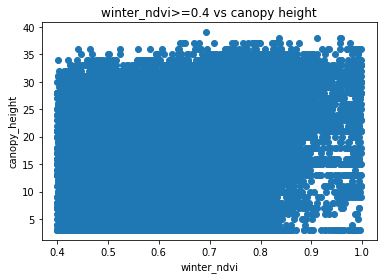

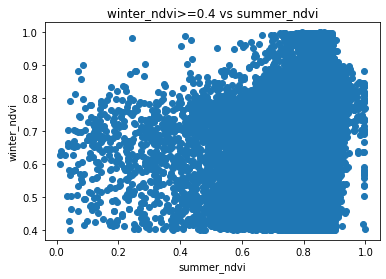

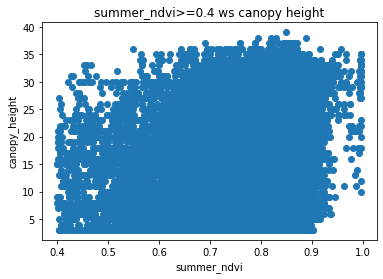

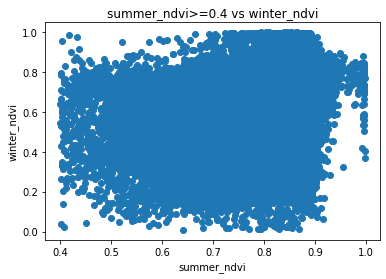

In [109]:
#To array - plot bands of interest to determine relationships in the datasets
img = canopyMasked 

img_bands = img.select('b1', 'w_ndvi', 's_ndvi').reduceRegion(reducer=ee.Reducer.toList(), geometry=extent, maxPixels=1e13, scale=30)

# print(band_array)
arr_b1 = np.array((ee.Array(img_bands.get('b1')).getInfo()))
arr_ndvi_w = np.array((ee.Array(img_bands.get('w_ndvi')).getInfo()))
arr_ndvi_s = np.array((ee.Array(img_bands.get('s_ndvi')).getInfo()))

arr_2d = np.array([arr_b1, arr_ndvi_w, arr_ndvi_s])
# print(arr_2d)

df = pd.DataFrame({'canopy_height':arr_2d[0, :], 'winter_ndvi':arr_2d[1, :], 'summer_ndvi':arr_2d[2, :]})
df.describe()

#ndvi >=0.4 in the winter
w_df = df.loc[df['winter_ndvi'] >= 0.4]
w_df.head(10)

plt.scatter(x=w_df['winter_ndvi'], y=w_df['canopy_height'])
plt.title('winter_ndvi>=0.4 vs canopy height')
plt.xlabel('winter_ndvi')
plt.ylabel('canopy_height')
plt.show()

plt.scatter(x=w_df['summer_ndvi'], y=w_df['winter_ndvi'])
plt.title('winter_ndvi>=0.4 vs summer_ndvi')
plt.xlabel('summer_ndvi')
plt.ylabel('winter_ndvi')
plt.show()

#ndvi >=0.4 in the summer
s_df = df.loc[df['summer_ndvi'] >= 0.4]
w_df.head(10)

plt.scatter(x=s_df['summer_ndvi'], y=s_df['canopy_height'])
plt.title('summer_ndvi>=0.4 ws canopy height')
plt.xlabel('summer_ndvi')
plt.ylabel('canopy_height')
plt.show()

plt.scatter(x=s_df['summer_ndvi'], y=s_df['winter_ndvi'])
plt.title('summer_ndvi>=0.4 vs winter_ndvi')
plt.xlabel('summer_ndvi')
plt.ylabel('winter_ndvi')
plt.show()


